<h1><center><b></b></center></h1>

<h1><center><b><u>Course Title:</u> Foundations of Computer Vision</b></center></h1>
<h2><center><b><u>Capstone Project:</u> Vision-Based Vehicle Detection and Tracking System </b></center></h2>


</br>

<p align="center">
<img height=400px src="https://miro.medium.com/v2/resize:fit:1400/1*QOJ4KNBl_6bT6iAA9ByOiQ.png"/></p>
<!-- <p align="center">Figure 1</p> -->
<p align="center"></p>


<u>Done by:</u> **Sandy Chkeir**

<u>Email:</u> **sandychkeir96@gmail.com**


## **🎯 Project Objectives**

What the Student Will Learn:

  1. Understand motion analysis through background subtraction and optical flow.

  2. Apply tracking techniques using sparse optical flow (Lucas-Kanade).

  3. Explore feature detection and matching with ORB + FLANN for object re-identification.

  4. Implement template matching for appearance-based tracking.

  5. Extract and visualize object trajectories across video frames.

  6. Estimate real-world metrics like object speed from pixel data.

  7. Compare traditional tracking methods to evaluate performance and robustness.

  8. Develop a full pipeline for detecting, tracking, and analyzing vehicle motion from raw video.

### Helper functions from previous sessions

In [ ]:
def draw_tracks(img, p0, p1, status):
    for i, (new, old) in enumerate(zip(p1, p0)):
        if status[i]:
            a, b = new.ravel()
            c, d = old.ravel()
            img = cv2.arrowedLine(
                img, (int(c), int(d)), (int(a), int(b)), (0, 255, 0), 2, tipLength=0.3
            )
            img = cv2.circle(img, (int(a), int(b)), 3, (0, 0, 255), -1)
    return img

def detect_features(img_gray, roi, method="shi_tomasi"):
    if roi is not None:
      x, y, w, h = roi
      roi_img = img_gray[y:y+h, x:x+w]
    else:
      roi_img = img_gray  # take the whole image

    if method == "shi_tomasi":
        corners = cv2.goodFeaturesToTrack(
            roi_img, maxCorners=100, qualityLevel=0.01, minDistance=7
        )
        if corners is not None:
            corners = corners.reshape(-1, 2)
            # Adjust coordinates to image frame
            corners[:, 0] += x
            corners[:, 1] += y
            return corners.astype(np.float32)
        else:
            return np.array([], dtype=np.float32).reshape(-1, 2)

    elif method == "harris":
        blockSize = 2
        ksize = 3
        k = 0.04
        dst = cv2.cornerHarris(roi_img, blockSize, ksize, k)
        dst = cv2.dilate(dst, None)
        thresh = 0.01 * dst.max()
        corners = np.argwhere(dst > thresh)
        if corners is not None and len(corners) > 0:
            corners = np.flip(corners, axis=1)  # swap to x,y
            corners = corners + np.array([x, y])
            return corners.astype(np.float32)
        else:
            return np.array([], dtype=np.float32).reshape(-1, 2)

    elif method == "sift":
        sift = cv2.SIFT_create()
        keypoints = sift.detect(roi_img, None)
        if len(keypoints) > 0:
            pts = np.array([kp.pt for kp in keypoints])
            pts[:, 0] += x
            pts[:, 1] += y
            return pts.astype(np.float32)
        else:
            return np.array([], dtype=np.float32).reshape(-1, 2)

    elif method == "orb":
        #orb = cv2.ORB_create(nfeatures=100, nlevels=10, patchSize =40, fastThreshold=20, scoreType=cv2.ORB_FAST_SCORE)
        orb = cv2.ORB_create()
        keypoints, descriptors = orb.detectAndCompute(roi_img, None)
        if len(keypoints) > 0:
            pts = np.array([kp.pt for kp in keypoints])
            #pts[:, 0] += x
            #pts[:, 1] += y
            return pts.astype(np.float32), keypoints, descriptors
        else:
            print("No keypoints detected")
            return np.array([], dtype=np.float32).reshape(-1, 2), None

    else:
        raise ValueError("Unknown feature detector method")

def match_features(img_bgr_1, img_bgr_2, kps1, kps2,
                   des1, des2, method="FLANN", draw=None, max_matches=100):
    if method == "FLANN":
        # FLANN params for ORB (binary descriptors)
        index_params = dict(algorithm=6,  # FLANN_INDEX_LSH
                            table_number=6,
                            key_size=12,
                            multi_probe_level=1)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        matches = flann.knnMatch(des1, des2, k=2)  # must be k=2 for ratio test
        print(f"Number of matches with FLANN: {len(matches)}")

        ratio_thresh = 0.6
        good_matches = []
        for match in matches:
            if len(match) == 2:
                m, n = match
                if m.distance < ratio_thresh * n.distance:
                    good_matches.append(m)
        print(f"Number of good matches with FLANN: {len(good_matches)}")

        if draw:
            img_matches = cv2.drawMatches(img_bgr_1, kps1,
                                          img_bgr_2, kps2,
                                          good_matches[:max_matches], None,
                                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
            return good_matches, img_matches
        else:
            return good_matches, None

    else:
        raise ValueError("Unknown feature matching method")

def compute_boundary_box(h, w, good_matches, kp1, kp2, MIN_MATCH_COUNT=10, draw=None):
  if len(good_matches) > MIN_MATCH_COUNT:
    # Extract location of good matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute homography matrix with RANSAC
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    matches_mask = mask.ravel().tolist()

    # Define points of query image's bounding box
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

    dst = cv2.perspectiveTransform(pts, M)

  else:
    print(f"Not enough matches are found - {len(good_matches)}/{MIN_MATCH_COUNT}")
    matches_mask = None

  return dst, matches_mask

## **Part 1: Prepare and Visualize Input Data**

In this section, you will learn to:

  - Load and process a video file using OpenCV to extract frames for analysis.

  - Select and define the target object (e.g., a vehicle) within the video using a bounding box.

  - Visualize individual or multiple video frames.

### **1. Import necessary libraries**

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import imutils

NB_PROCESSED_FRAMES = 50 # number of frames to process - dont take the whole video

In [ ]:
# Helper function to plot a list of images
def plot_frames(list_frames, cmap=None, name=None):
  # number of cols and rows of plotting grid
  n_cols = 5
  n_rows = int(np.ceil(len(list_frames) / n_cols))

  plt.figure(figsize=(n_cols * 4, n_rows * 3))
  for i, img in enumerate(list_frames):
      plt.subplot(n_rows, n_cols, i + 1)
      if cmap is not None:
        plt.imshow(img, cmap=cmap)
      else:
        plt.imshow(img)
      plt.title(f"Frame {i+1}")
      plt.axis('off')
  plt.subplots_adjust(wspace=0.05, hspace=0.05)
  plt.tight_layout()
  if name is not None:
    plt.savefig(name)
  plt.show()

### **2. Load the traffic video and check number of frames**

In [ ]:
# Load the video
video_path = "los_angeles.mp4"  # Adjust path if needed

### ADD your code here

# 1. Load the video
# 2. Get the width and height of video frames
# 3. Get the number of frames per seconds (fps)
# 4. Get the number of frames

cap = None
frame_width, frame_height = None, None
fps = None
nb_frames = None

### Sandy's code

cap = cv2.VideoCapture(video_path)
frame_width, frame_height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
nb_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [ ]:
cap, fps, nb_frames

(< cv2.VideoCapture 0x7d26de35c150>, 23.976023976023978, 332)

In [ ]:
dt_total = nb_frames / fps
print(f"Time per frame: {dt_total:.2f} seconds")
dt_per_frame = dt_total / nb_frames
print(f"Time per frame: {dt_per_frame:.2f} seconds")

Time per frame: 13.85 seconds
Time per frame: 0.04 seconds


### **3. First visualization of video frames**

In this part, you has to store the first `NB_PROCESSED_FRAMES` frames in a variable `list_input_frames` and then visualize them using the helper function `plot_frames`.

In [ ]:
### ADD YOUR CODE HERE
list_input_frames = []
# ...

### Sandy's code
for _ in range(NB_PROCESSED_FRAMES):
    ret, frame = cap.read()
    if not ret:
        break
    list_input_frames.append(frame)

print(len(list_input_frames))

#### Visualize frames
plot_frames(list_input_frames, None,"processed_frames.jpg")

Output hidden; open in https://colab.research.google.com to view.

### **4. Check the target car**

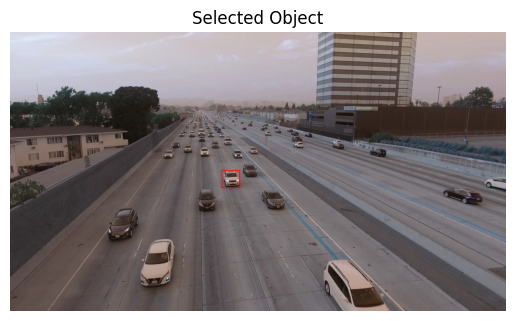

In [ ]:
# Read the first frame
first_frame = list_input_frames[0].copy()

# Coordinates: (x, y, width, height) -- GIVEN
x_car, y_car, w_car, h_car = 820, 535, 69, 67

selected_car = first_frame[y_car:y_car + h_car, x_car:x_car + w_car]

# plot the target car
cv2.rectangle(first_frame, (x_car, y_car), (x_car + w_car, y_car + h_car), (255, 0, 0), 2)
plt.imshow(first_frame)
#plt.imshow(selected_car)
plt.title("Selected Object")
plt.axis('off')
plt.savefig("selected_car.jpg")
plt.show()


## **Part 2: Car Tracking and Trajectory Estimation with Optical Flow**

In this section, you should fill up the following tasks:
  - Detect Tomasi features at the first frame of the target car
  - Track these features over the video frames using a optical flow algorithm
  - Update bounding box over evry frame
  - Estimate the car's trajectory by saving the center of the bounding box
  - visualize the different results

**Note:** The height and the width of the target car is assumed fixed.

In [ ]:
#### ADD YOUR CODE HERE

# Functions to be used
# . cv2.goodFeaturesToTrack()
# . cv2.calcOpticalFlowPyrLK()
# . cv2.circle() / cv2.rectangle()

track_frames = [] # to store frames with bounding box
trajectory_opt_flow = [(x_car + w_car // 2, y_car + h_car // 2)] # to store car's trajectory
start, end = [], []

# Shi-Tomasi to detect features from the ROI
# fixed width and height of the target car
# Region of interest
start_time = time.time()
roi = x_car, y_car, w_car, h_car # that's how the input argument defined in detect_features()
old_frame = list_input_frames[0].copy() # original frame
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
detected_features = detect_features(old_gray, roi, method="shi_tomasi")
print("Number of detected features by Shi-Tomasi: ", len(detected_features))
print(detected_features.shape)

# Track these features over each frame using LK-OF
lk_params = dict(
    winSize=(15, 15),
    maxLevel=3,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.01),
)

#Set initial old_points
track_frames = [first_frame]
old_pts = detected_features.reshape(-1, 1, 2) # old points
mid_old = (x_car + w_car // 2, y_car + h_car // 2)

for i in range(1, len(list_input_frames)):
  next_frame = list_input_frames[i].copy() # next frame
  next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

  new_pts, status, error = cv2.calcOpticalFlowPyrLK(old_gray,next_gray, old_pts,
                                                  None, **lk_params)
  status = status.reshape(-1)

  good_new = new_pts[status == 1]
  good_old = old_pts[status == 1]

  print("Number of successfully tracked features: ", len(good_new))

  tmp = next_frame.copy()
  new_tmp = tmp  #draw_tracks(tmp, good_new, good_old, status)

  if len(good_new) > 0:
    x_min, y_min = np.squeeze(np.min(good_new, axis=0).astype(int))
    x_max, y_max = np.squeeze(np.max(good_new, axis=0).astype(int))
    cv2.rectangle(new_tmp, (x_min, y_min), (x_max, y_max), (255, 0, 255), 2)

    # get center of bounding box i.e. rectangle
    mid_new = ((x_min + x_max) // 2, (y_min + y_max) // 2)

    cv2.circle(new_tmp, mid_old, 4, (255, 0, 0), -1)
    cv2.circle(new_tmp, mid_new, 4, (255, 0, 255), -1)
    cv2.putText(new_tmp, f"Old loc ({mid_old[0]}, {mid_old[1]})",(100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)
    cv2.putText(new_tmp, f"New loc ({mid_new[0]}, {mid_new[1]})",(100,160), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 3)
    #cv2.arrowedLine(new_tmp, mid_old, mid_new, (0,255,0), 4)

    # Updates
    start.append(mid_old)
    end.append(mid_new)
    mid_old = mid_new
    track_frames.append(new_tmp)
    trajectory_opt_flow.append(mid_new)
    good_old = good_new

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")
#### Plot results
plot_frames(track_frames, None, "Tracked_WhiteCar_1.jpg")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
x_car, y_car, w_car, h_car, img_traj.shape

(820, 535, 69, 67, (1080, 1920, 3))

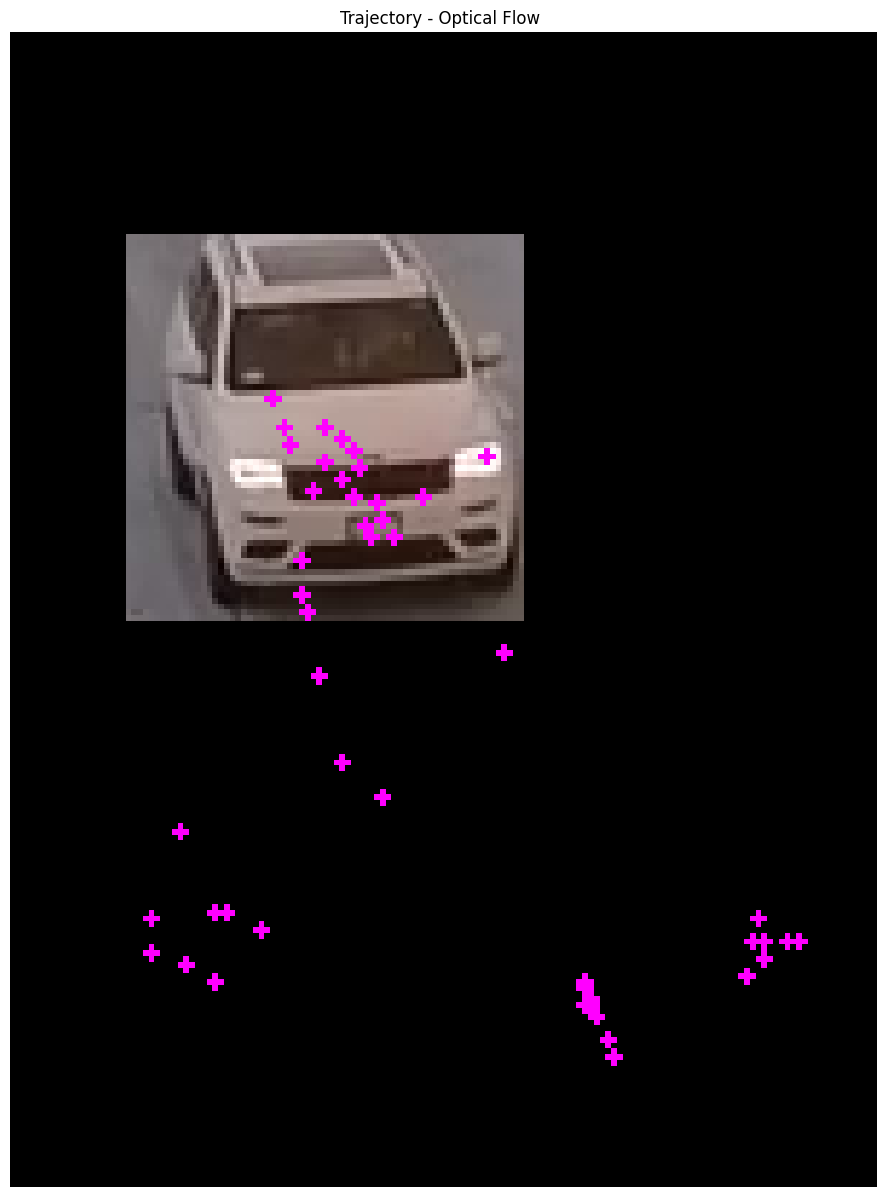

In [ ]:
# plot trajectory
img_traj = np.zeros_like(list_input_frames[0])
img_traj[y_car:y_car+h_car, x_car:x_car+w_car] = list_input_frames[0][y_car:y_car+h_car, x_car:x_car+w_car]

for pt in trajectory_opt_flow:
    cv2.circle(img_traj, pt, 1, (255, 0, 255), -1)
    #cv2.putText(img_traj, f"{i}", (pt[0], pt[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255, 255, 255),1)

plt.figure(figsize=(15, 15))
plt.title("Trajectory - Optical Flow ")
plt.imshow(img_traj[500:700,800:950]) #[500:700,800:950]
plt.savefig("Trajectory_OF.jpg")
plt.axis('off')
plt.show()

## **Part 3: Repeat the previous part with Features Matching**

In this section, you should compare the previous results with a feature matching approach. The tasks might be summarized as follows:
  - Detect features at the first frame of the target car
  - Detect features at each video frame
  - Match these features over the video frames using a features matching algorithm
  - Update bounding box over every frame
  - Estimate the car's trajectory by saving the center of the bounding box
  - visualize the different results

**Note:** Use ORB as features detector and FLANN as features matcher.

Number of first detected features by orb:  62
Number of matches with FLANN: 62
Number of good matches with FLANN: 7
Number of matches with FLANN: 62
Number of good matches with FLANN: 9
Number of matches with FLANN: 62
Number of good matches with FLANN: 7
Number of matches with FLANN: 62
Number of good matches with FLANN: 6


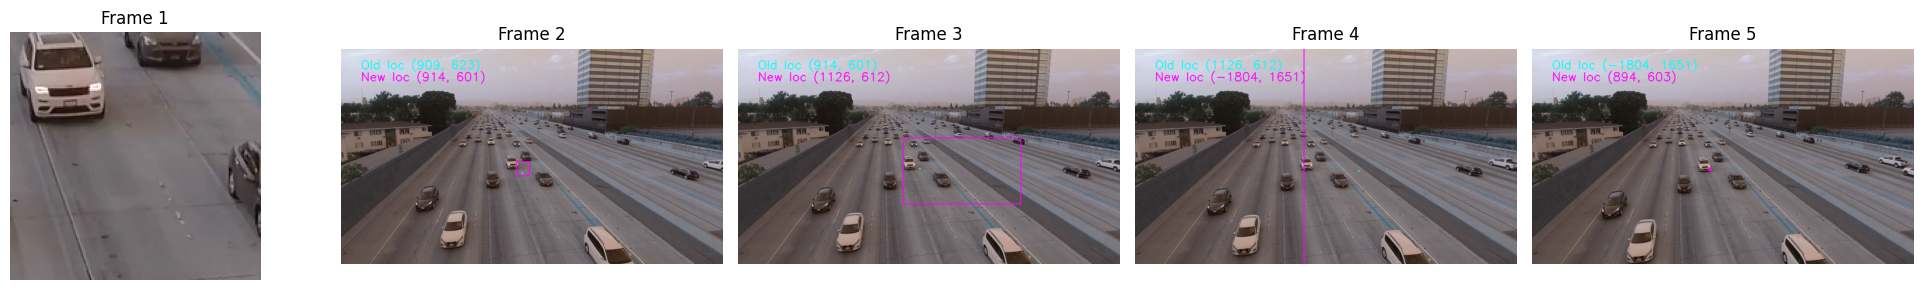

In [ ]:
#### ADD YOUR CODE HERE

# Functions to be used
# . cv2.ORB_create
# . cv2.FlannBasedMatcher
# . cv2.circle() / cv2.rectangle()

track_frames = [] # to store frames with bounding box
trajectory_fm = [(x_car + w_car // 2, y_car + h_car // 2)] # to store car's trajectory

# ORB detector and descriptor to detect features from the ROI
# fixed width and height of the target car
# Region of interest
w_new, h_new = w_car+110, h_car+110
roi = x_car, y_car, w_new, h_new  # that's how the input argument defined in detect_features()
old_frame = list_input_frames[0].copy() # original frame
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
old_kps_arr, old_kps, old_des = detect_features(old_gray, roi, method="orb")
print("Number of first detected features by orb: ", len(old_kps))

# Match these features over each frame using FLANN

#Set initial old_points
track_frames = [old_frame[y_car:y_car+h_new, x_car: x_car+w_new]]
old_pts = old_kps_arr.reshape(-1, 1, 2) # old points
mid_old = (x_car + w_new // 2, y_car + h_new // 2) # old midpoint coordinates of the bounding box

#for i in range(1, len(list_input_frames)):
for i in range(1, 5):
  next_frame = list_input_frames[i].copy() # next frame
  next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

  next_kps_arr, next_kps, next_des = detect_features(next_gray, roi=None, method="orb")
  #print("Number of first detected features by orb: ", len(next_kps))

  new_pts, drawn_pts = match_features(old_frame[y_car:y_car+h_new, x_car: x_car+w_new], next_frame, old_kps, next_kps,
                   old_des, next_des, method="FLANN", draw=True, max_matches=100)

  query = old_frame[y_car:y_car+h_new, x_car: x_car+w_new]
  h, w, _ = query.shape
  dst_points, matches_mask = compute_boundary_box(h, w, new_pts, old_kps, next_kps, MIN_MATCH_COUNT=-1)

  good_new = dst_points
  good_old = old_pts

  #print("Number of good matched features: ", len(good_new))

  tmp = next_frame.copy()
  new_tmp = tmp #draw_tracks(tmp, good_new, good_old, status)

  if len(good_new) > 0:
    x_min, y_min = np.squeeze(np.min(good_new, axis=0).astype(int))
    x_max, y_max = np.squeeze(np.max(good_new, axis=0).astype(int))
    cv2.rectangle(new_tmp, (x_min, y_min), (x_max, y_max), (255, 0, 255), 4)

    # get center of bounding box i.e. rectangle
    mid_new = ((x_min + x_max) // 2, (y_min + y_max) // 2)

    cv2.circle(new_tmp, mid_old, 4, (0, 255, 255), -1)
    cv2.circle(new_tmp, mid_new, 4, (255, 0, 255), -1)
    cv2.putText(new_tmp, f"Old loc ({mid_old[0]}, {mid_old[1]})",(100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 255), 3)
    cv2.putText(new_tmp, f"New loc ({mid_new[0]}, {mid_new[1]})",(100,160), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 3)

    # Updates
    mid_old = mid_new
    track_frames.append(new_tmp)
    trajectory_fm.append(mid_new)
    good_old = good_new

#### Plot results
plot_frames(track_frames, cmap=None, name = "Matched_WhiteCar_1.jpg")

In [ ]:
# plot trajectory
img_traj = np.zeros_like(list_input_frames[0])
img_traj[y_car:y_car+h_new, x_car:x_car+w_new] = list_input_frames[0][y_car:y_car+h_new, x_car:x_car+w_new]

for pt in trajectory_fm:
    cv2.circle(img_traj, pt, 4, (255, 0, 0), -1)

plt.figure(figsize=(15, 15))
plt.title("Trajectory - Features Matching")
plt.imshow(img_traj)
plot_frames(track_frames, None, "Trajectory_FM.jpg")
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## **Part 4: Repeat the previous step with Template Matching**

Do the same task but with template matching algorithm and then compare the results of three parts 2, 3 and 4. Conclude

In [ ]:
#### ADD YOUR CODE HERE

# Functions to be used
# . cv2.matchTemplate
# . cv2.circle() / cv2.rectangle()

track_frames = [] # to store frames with bounding box
trajectory_tm = [(x_car + w_car // 2, y_car + h_car // 2)] # to store car's trajectory

# Template to be matched with each next frame
# fixed width and height of the target car
# Region of interest
start_time = time.time()

roi = x_car, y_car, w_car, h_car # that's how the input argument defined in detect_features()
old_frame = list_input_frames[0].copy() # original frame
template = old_frame[y_car: y_car+h_car, x_car:x_car+w_car]
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
w, h = template_gray.shape[::-1]
mid_old = (x_car + w_car // 2, y_car + h_car // 2)

MATCH_THRESHOLD = 0.5  # Confidence threshold

for i in range(1, len(list_input_frames)):

  frame = list_input_frames[i].copy()
  res = cv2.matchTemplate(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), template_gray, cv2.TM_CCOEFF_NORMED) # used a default method
  min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

  if max_val > MATCH_THRESHOLD:
    print(f"[+] Detected with confidence {max_val:.2f}")
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(frame, top_left, bottom_right, (255,0,0), 5)

    mid_new = ((top_left[0] + bottom_right[0]) // 2, (top_left[1] + bottom_right[1]) // 2)

    cv2.circle(frame, mid_old, 4, (0, 0, 255), -1)
    cv2.circle(frame, mid_new, 4, (0, 0, 255), -1)

    # Updates
    mid_old = mid_new
    track_frames.append(frame)
    trajectory_tm.append(mid_new)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")
#### Plot results
plot_frames(track_frames, None, "TM_WhiteCar_1.jpg")

Output hidden; open in https://colab.research.google.com to view.

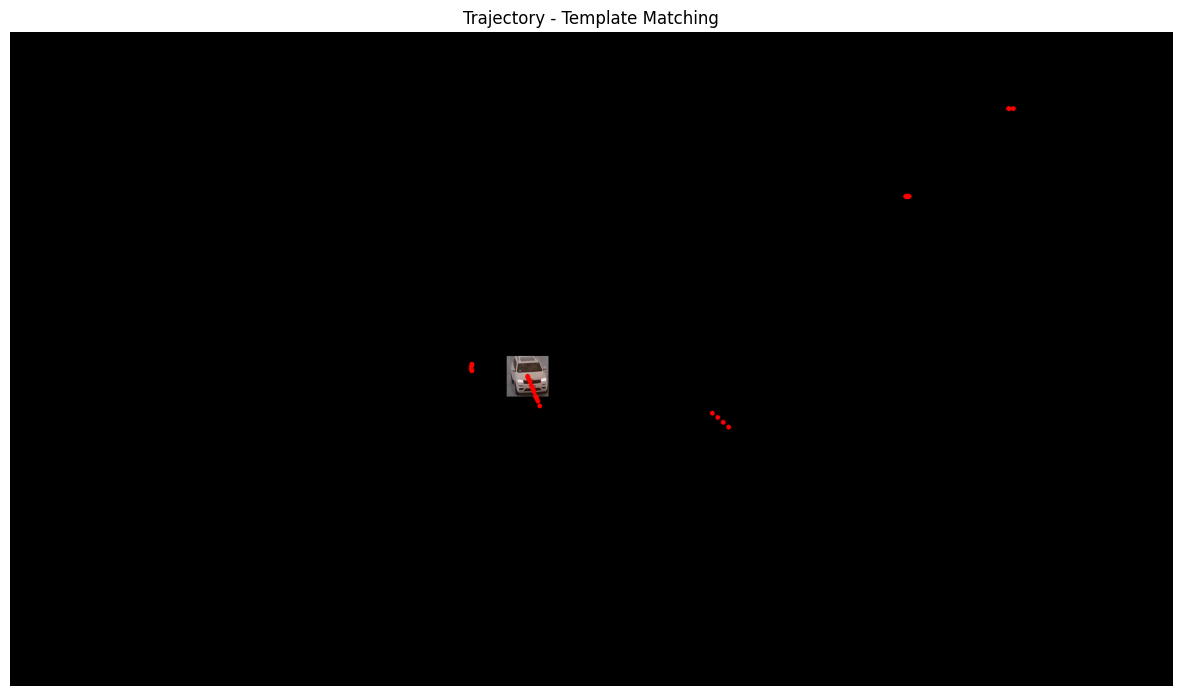

In [ ]:
# plot trajectory
img_traj = np.zeros_like(list_input_frames[0])
img_traj[y_car:y_car+h_car, x_car:x_car+w_car] = list_input_frames[0][y_car:y_car+h_car, x_car:x_car+w_car]

for pt in trajectory_tm:
    cv2.circle(img_traj, pt, 4, (255, 0, 0), -1)

plt.figure(figsize=(15, 15))
plt.title("Trajectory - Template Matching")
plt.imshow(img_traj)
plt.savefig("Trajectory_TM.jpg")
plt.axis('off')
plt.show()

## **Part 5: Optional**

### **a. Car Speed Estimation**

In [ ]:
# Calculate speed between each pair of frames
def calculate_avg_speed(trajectory, meters_per_pixel, dt_per_frame):
  speeds_kmh = None
  speeds = []
  ### ADD YOUR CODE HERE
  for i in range(1, len(trajectory)):
    D_pixels = math.dist(trajectory[i], trajectory[i-1])
    D_meters = D_pixels * meters_per_pixel
    speeds.append(D_meters/dt_per_frame)

  av_speed = np.sum(speeds)/len(speeds)
  speeds_kmh = 3.6 * av_speed
  return speeds_kmh

In [ ]:
# Time per frame change
dt_total = nb_frames / fps
print(f"Total time: {dt_total:.2f} seconds")
dt_per_frame = dt_total / nb_frames
print(f"Time per frame: {dt_per_frame:.2f} seconds")

# Estimated scale
meters_per_pixel = 0.1

avg_speed_of = calculate_avg_speed(trajectory_opt_flow[:6], meters_per_pixel, dt_per_frame=dt_per_frame)
avg_speed_fm = calculate_avg_speed(trajectory_fm[:6], meters_per_pixel, dt_per_frame=dt_per_frame)
avg_speed_tm = calculate_avg_speed(trajectory_tm[:6], meters_per_pixel, dt_per_frame=dt_per_frame)

print(f"Average speed of Optical Flow: {avg_speed_of} km/h")
print(f"Average speed of Features Matching: {avg_speed_fm} km/h")
print(f"Average speed of Template Matching: {avg_speed_tm} km/h")

Total time: 13.85 seconds
Time per frame: 0.04 seconds
Average speed of Optical Flow: 33.604917746717305 km/h
Average speed of Features Matching: 13559.70567433867 km/h
Average speed of Template Matching: 35.78012659473016 km/h


### **b. Tracking multiple Cars**

In [ ]:
# the target cars
# x_car1, y_car1, w_car1, h_car1 = 820, 535, 69, 67
# x_car2, y_car2, w_car2, h_car2 = 727, 605, 64, 91
target_bboxes = {
    "car_1": (820, 525, 69, 67),   # car 1
    "car_2": (727, 605, 64, 91),   # car 2
}

#### ADD YOUR WORK HERE USING OPTICAL FLOW

In [ ]:
track_frames = [] # to store frames with bounding box

trajectory_opt_flow = dict(car_1=[(target_bboxes["car_1"][0] + target_bboxes["car_1"][2] // 2, target_bboxes["car_1"][1] + target_bboxes["car_1"][3] // 2)],
                           car_2=[(target_bboxes["car_2"][0] + target_bboxes["car_2"][2] // 2, target_bboxes["car_2"][1] + target_bboxes["car_2"][3] // 2)])

detected_features = dict(car_1 = None,
                         car_2 = None)

old_pts = dict(car_1 = None,
               car_2 = None)

new_pts = dict(car_1 = None,
               car_2 = None)

mid_old = dict(car_1 = None,
               car_2 = None)

mid_new = dict(car_1 = None,
               car_2 = None)

good_old = dict(car_1 = None,
               car_2 = None)

good_new = dict(car_1 = None,
               car_2 = None)

colors = dict(car_1 = dict(old=(255, 0, 0), new=(255, 0, 255)),
              car_2 = dict(old=(0, 0, 255), new=(255, 255, 0)))

pts = dict(car_1 = dict(old=(100,100), new=(100,160)),
              car_2 = dict(old=(100,220), new=(100,280)))
# Shi-Tomasi to detect features from the ROI

start_time = time.time()

old_frame = list_input_frames[0].copy() # original frame
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

for key, bbox in target_bboxes.items():
  detected_features[key] = detect_features(old_gray, bbox, method="shi_tomasi")

  print("Number of detected features by Shi-Tomasi: ", len(detected_features[key]))
  print(detected_features[key].shape)

  #Set initial old_points
  old_pts[key] = np.array(detected_features[key], dtype=np.float32).reshape(-1, 1, 2) # old points
  mid_old[key] = (target_bboxes[key][0] + target_bboxes[key][2] // 2, target_bboxes[key][1] + target_bboxes[key][3] // 2)

track_frames = [first_frame]

# Track these features over each frame using LK-OF
lk_params = dict(
    winSize=(15, 15),
    maxLevel=3,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.01),
)

for i in range(1, len(list_input_frames)):
  next_frame = list_input_frames[i].copy() # next frame
  next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

  new_tmp = next_frame.copy()

  for key, bbox in target_bboxes.items():

    new_pts[key], status, _ = cv2.calcOpticalFlowPyrLK(old_gray,next_gray, old_pts[key],
                                                  None, **lk_params)
    status = status.reshape(-1)

    good_new[key] = new_pts[key][status == 1]
    good_old[key] = old_pts[key][status == 1]

    #print("Number of successfully tracked features: ", len(good_new[key]))

    if len(good_new[key]) > 0:
      x_min, y_min = np.squeeze(np.min(good_new[key], axis=0).astype(int))
      x_max, y_max = np.squeeze(np.max(good_new[key], axis=0).astype(int))
      cv2.rectangle(new_tmp, (x_min, y_min), (x_max, y_max), colors[key]["new"], 2)

      # get center of bounding box i.e. rectangle
      mid_new[key] = ((x_min + x_max) // 2, (y_min + y_max) // 2)

      cv2.circle(new_tmp, mid_old[key], 4, colors[key]["old"], -1)
      cv2.circle(new_tmp, mid_new[key], 4, colors[key]["new"], -1)
      cv2.putText(new_tmp, f"{key}, Old loc ({mid_old[key][0]}, {mid_old[key][1]})", pts[key]["old"], cv2.FONT_HERSHEY_SIMPLEX, 2, colors[key]["old"], 3)
      cv2.putText(new_tmp, f"{key}, New loc ({mid_new[key][0]}, {mid_new[key][1]})", pts[key]["new"], cv2.FONT_HERSHEY_SIMPLEX, 2, colors[key]["new"], 3)

      # Updates
      mid_old[key] = mid_new[key]
      trajectory_opt_flow[key].append(mid_new[key])
      good_old[key] = good_new[key]

  track_frames.append(new_tmp)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

#### Plot results
plot_frames(track_frames, None, "Tracked_White&BlackCars_1.jpg")

Output hidden; open in https://colab.research.google.com to view.

### **c. Backgrround Subtraction**

Background subtraction is a computer vision technique used to detect moving objects in video by separating the dynamic foreground from the static background.

Your goal is to detect all moving cars in the video following the following steps:

 - Use OpenCV's Background Subtractor (`cv2.createBackgroundSubtractorMOG2`).

 - Process each frame:

    - Apply background subtraction.

    - Clean up noise with morphological operations (think about `cv2.dilate`)

    - Find contours (blobs) representing moving objects.

    - Draw bounding boxes around those blobs (likely cars).

 - Display the detections.

In [ ]:
#### ADD YOUR CODE HERE

# main function: cv2.createBackgroundSubtractorMOG2()

detected_frames = []  # store frames with detected moving cars
list_fg_mask = []     # store foreground masks
bs_mask = []          # store background masks
m1 = []
m2 = []

bs = cv2.createBackgroundSubtractorMOG2(detectShadows=False)

for i in range(len(list_input_frames)):
  frame = list_input_frames[i].copy()
  fg_mask = bs.apply(frame) # returns a mask: foreground=255, background=0, shadows=127
  bs_mask.append(fg_mask)

  mask_m1 = cv2.dilate(fg_mask, None, iterations=1)
  mask_m2 = cv2.erode(mask_m1, None, iterations=2) # 2 iterations is better than 1

  detected_frame = cv2.bitwise_and(frame, frame, mask=mask_m2)

  detected_frames.append(detected_frame)
  m1.append(mask_m1)
  m2.append(mask_m2)

## plot results
print("Input frames - no processing")
plot_frames(list_input_frames[:5])
print("O/P 1 - Applied background subtractor")
plot_frames(bs_mask, "gray")
print("O/P 2 - Applied Morphological dilation")
plot_frames(m1, "gray", "BackSubtract.jpg")
print("O/P 3 - Applied Morphological erosion")
plot_frames(m2, "gray")
print("O/P 4 - Detected frames")
plot_frames(detected_frames, name="BackSubtract_final.jpg")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import imutils
from imutils import perspective
from imutils import contours

# Finding contours and making bounding boxes around them
cntrs = []
cntrd_frames = []

for i in range(len(list_input_frames)):
  res = cv2.findContours(m2[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cntrs.append(res[0])

  vis_img = list_input_frames[i].copy()
  for contour in cntrs[i]:
    # if the contour is not sufficiently large, ignore it
    if cv2.contourArea(contour) < 90:
      continue
    # compute the rotated bounding box of the contour
    box = cv2.minAreaRect(contour)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")

	  # order the points in the contour such that they appear
	  # in top-left, top-right, bottom-right, and bottom-left
	  # order, then draw the outline of the rotated bounding box
    box = imutils.perspective.order_points(box)
    cv2.drawContours(vis_img, [box.astype("int")], -1, (0, 255, 255), 2)

	  # loop over the original points and draw them
    for (x, y) in box:
      cv2.circle(vis_img, (int(x), int(y)), 5, (0, 255, 255), -1)

  cntrd_frames.append(vis_img)

plot_frames(cntrd_frames,name= "Output.jpg")

Output hidden; open in https://colab.research.google.com to view.

## **Conclusion**

### **1. Analysis:**

*   Feature tracking (FT): we detected the features of the target car in frame 1 and then started tracking those features from the second frame onwards. With the optical flow method, we can see good tracking of the target car until the 9th frame, where the bounding box nicely bounds the car. In the following frames, part of the car can still be tracked; however, the new trajectory points we save are not perfectly aligned with the car's actual trajectory. In the last 10 frames, we lose track of the car, and the bounding box no longer surrounds it. Regarding repeatability, the car appears slightly larger in the frames as it moves forward, which may explain why the bounding box slowly extends beyond the car's borders.

*   Tracking multiple cars was interesting to try. With the black car as the target, the results differed from those of the white car. This is likely because several visually similar black cars are close to the target, and since we rely on the first frame, the LK-OF struggles to consistently track the correct car once the motion becomes large. As a result, the bounding box sometimes surrounds other black cars in the scene rather than the target one. A possible improvement would be to re-detect features in each new bounding box from the next frame. Still, a threshold or decision criterion would be necessary to decide whether to use the newly detected box or keep the old one, to avoid even worse tracking drift.

*   Feature matching (FM) using "ORB + FLANN": with the given ROI, the method did not work well. The main problem appeared even before the matching step: ORB failed to detect enough keypoints within the ROI. We enlarged the area to get some keypoints detected, but tuning ORB parameters did not improve the results. Even when keypoints were found, the number of good matches was very small, and only a few frames produced usable results. Most frames suffered from too few good matches to reliably compute a homography matrix.

*   Template Matching (TM): we used the ROI containing the target white car as the template image for the algorithm. For the first few frames (up to around frame 12), the tracking was very good. At this stage, the white car was still far from the camera and remained close in size to the template. Later, as the car grew larger in the frame, tracking was completely lost. The tracked pixels diverged significantly compared to the FT results. In addition, newly appearing cars of similar size and appearance to the template were also falsely captured. Since TM is not time-dependent, it is unaffected by large or subtle motions, but it is highly sensitive to changes in scale and appearance.

*   Average speed estimation: it made sense to calculate the car’s speed using only the first five frames. In this range, the TM method tracked the car with a confidence of about 0.70. Within those frames, both FT and TM produced roughly similar speed estimates. This was not the case for FM, which failed to provide reliable tracking for speed calculation.

*   Background Subtraction (MOG2):
    * The background subtractor based on a mixture of Gaussians was applied to the first 50 frames of the video. The algorithm performed well in the initial frames, successfully identifying moving objects. Its performance then began to deteriorate, particularly for cars moving near the front of the captured scene.
    * The method also showed a persistence effect: foreground pixels sometimes remained active beyond the car’s current position, creating sort of “ghost trails.” This might be reflecting the memory of previous pixel locations in the Gaussian model, which struggles to adapt when objects move continuously across frames.
    * In addition, cars located close to each other were often interpreted as a single object, resulting in bounding boxes that enclosed multiple vehicles at once.


### **2. Approach of the qualitative comparisons:**

To compare the methods, I evaluated them against a set of qualitative indicators commonly used in feature tracking and matching. These indicators reflect both performance and practical usability:

| Indicator      | Focus                                             |
| -------------- | ------------------------------------------------- |
| Stability      | Features remain consistent across frames          |
| Repeatability  | Same features are detected under small variations (scale, rotation, etc.) |
| Large motions  | Ability to handle significant object displacement |
| Subtle motions | Sensitivity to fine displacements                 |
| Speed          | Computational efficiency                          |
| Density        | Number of features produced (sparse vs dense)     |
| Drift          | Long-term consistency without gradual shifts      |
| Robustness     | Tolerance to illumination changes or noise        |
| Ease of use    | Reliability without heavy parameter tuning        |


### **3. Qualitative comparisons:**

| Approach | Algorithms used | Stability | Repeatability | Large motions | Subtle motions | Speed | Density | Drift | Robustness (illumination/noise) | Ease of use |
| ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- |
| Feature tracking | Shi-Tomasi + LK OF | + | __ | -- | ++ | 0.349 sec | ++ |  +|__  | ++|
| Feature matching | ORB + FLANN | -- | -- | .. | .. |  | -- |  --|-- (noise/resolution) | --|
| Template matching | standard way | + | -- (scale) | .. | .. | 2.23 sec | __ |  ..|__  | ++|

*Signs:*


*   -- : bad
*   .. : not relevant
*   __ : hard to judge
*   +.  : okay
*   ++ : good
*   +++ : very good

### **4. Concluding points**

*   All tested approaches performed reasonably well in analyzing vehicle motion from raw video, except ORB+FLANN feature matching.
*   Feature tracking worked well for small motions but degraded when (1) object motion was large or (2) the target object was visually similar to others.
*   ORB+FLANN feature matching failed to produce reliable tracks, likely due to low video resolution, which limited ORB detection and hampered matching.
*   Template matching was effective as long as the ROI size remained consistent with the initial template.
*   Background subtraction showed strong potential for detecting all moving objects, providing good visual accuracy. However, it struggled with nearby objects, and in long-term sequences the Gaussian model may become a limitation.

